<a href="https://colab.research.google.com/github/UniversalBuilder/Python-and-Microscopy/blob/master/U_Net_4_superresolution_in_EM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Training School # 4 of NEUBIAS COST Action
February 29th-March 3rd, 2020, Bordeaux

# Deep Learning example: U-Net for super-resolution

---
## Introduction
This is a notebook that shows how to design and train a [U-Net](https://en.wikipedia.org/wiki/U-Net)-like network for super-resolution on Electron Miscroscopy (EM) images. The aim is to train the network using low resolution versions of the images as input, and the high resolution versions as output.

<figure>
<center>
<img src="https://drive.google.com/uc?id=1KUCwas63FD6AfiKOetiGjLRR6oldNkKC" width="450">
</figure>

The resulting model will be downloaded in a format compatible with [DeepImageJ](https://deepimagej.github.io/deepimagej/index.html).

**Authors**: [Ignacio Arganda-Carreras](https://sites.google.com/site/iargandacarreras/), Andoni Rodriguez.

## Data
The image data used in the notebook was produced by [Lichtman Lab at Harvard University](https://lichtmanlab.fas.harvard.edu/) (Daniel R. Berger, Richard Schalek, Narayanan "Bobby" Kasthuri, Juan-Carlos Tapia, Kenneth Hayworth, Jeff W. Lichtman). Their corresponding biological findings were published in [Cell (2015)](https://www.ncbi.nlm.nih.gov/pubmed/26232230).
The training and test data sets are both 3D stacks of 100 sections from a serial section Scanning Electron Microscopy (ssSEM) data set of mouse cortex. The microcube measures 6 x 6 x 3 microns approx., with a resolution of 6 x 6 x 30 nm/voxel. For simplicity, in this notebook we will only use 10 sections of the test set.

## Getting started
First, we make sure we are using Tensorflow version compatible with [DeepImageJ](https://deepimagej.github.io/deepimagej/index.html) (<= 1.13).


In [0]:
# Use Tensorflow and Keras versions compatible with DeepImageJ
%pip install tensorflow-gpu==1.13.1
%pip install keras==2.2.4

     |████████████████████████████████| 345.2MB 48kB/s 
     |████████████████████████████████| 3.2MB 37.5MB/s 
     |████████████████████████████████| 368kB 52.8MB/s 
ERROR: tensorflow 2.2.0rc3 has requirement tensorboard<2.3.0,>=2.2.0, but you'll have tensorboard 1.13.1 which is incompatible.
ERROR: tensorflow 2.2.0rc3 has requirement tensorflow-estimator<2.3.0,>=2.2.0rc0, but you'll have tensorflow-estimator 1.13.0 which is incompatible.
  Found existing installation: tensorboard 2.2.0
    Uninstalling tensorboard-2.2.0:
      Successfully uninstalled tensorboard-2.2.0
  Found existing installation: tensorflow-estimator 2.2.0rc0
    Uninstalling tensorflow-estimator-2.2.0rc0:
      Successfully uninstalled tensorflow-estimator-2.2.0rc0
     |████████████████████████████████| 317kB 12.8MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


Then, we load our Google Drive as a local folder so we can access the image files.

(Notice we expect you to have that folder directly under `My Drive`, so all the paths of this notebook work without changes.)

In [0]:
# load drive as local folder
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Now we should be able to read the list of **100 training images**.

In [0]:
import os

# Path to the training images
train_path = 'drive/My Drive/Neubias-TS15-images/train/'

# Read the list of file names
train_filenames = [x for x in os.listdir( train_path ) if x.endswith(".tif")]

print( 'Images loaded: ' + str( len(train_filenames)) )

Images loaded: 100


Next, we read the 100 images into memory. This **may take some time (~1 minute)** the first time we execute the cell.


Text(0.5, 1.0, 'Full-size training image')

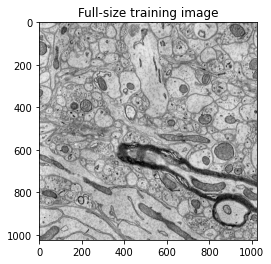

In [0]:
from skimage.util import img_as_ubyte
from skimage import io
from matplotlib import pyplot as plt

# read training images
train_img = [ img_as_ubyte( io.imread( train_path + x ) ) for x in train_filenames ]

# display first image
plt.imshow( train_img[0], 'gray' )
plt.title( 'Full-size training image' )

## Preparing the training data
Now, we are going to create the training set by cropping the input images into **patches of 256 x 256 pixels**.


Text(0.5, 1.0, 'Training patch at full resolution')

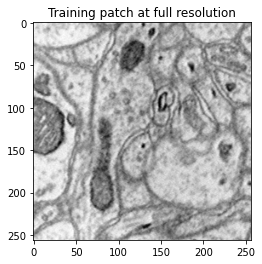

In [0]:
# create patches of 256x256 pixels => split each image in 4x4 tiles

def create_patches( imgs, num_x_patches, num_y_patches ):
    ''' Create a list of images patches out of a list of images
    Args:
        imgs: list of input images
        num_x_patches: number of patches in the X axis
        num_y_patches: number of patches in the Y axis
        
    Returns:
        list of image patches
    '''
    original_size = imgs[0].shape
    patch_width = original_size[ 0 ] // num_x_patches
    patch_height = original_size[ 1 ] // num_y_patches
    
    patches = []
    for n in range( 0, len( imgs ) ):
        image = imgs[ n ]
        for i in range( 0, num_x_patches ):
            for j in range( 0, num_y_patches ):
                patches.append( image[ i * patch_width : (i+1) * patch_width,
                                      j * patch_height : (j+1) * patch_height ] )
    return patches

# use method to create patches
train_patches = create_patches( train_img, 4, 4 )

# display one patch
plt.imshow( train_patches[0], 'gray' )
plt.title( 'Training patch at full resolution' )

# We will use these patches as "ground truth" for training

Since we do not have the equivalent images at low resolution, we **simulate them by using Gaussian blur** (see the work of [Fang *et al*. (2019)](https://www.biorxiv.org/content/10.1101/740548v3) for more details about this strategy).

Text(0.5, 1.0, 'Ground truth')

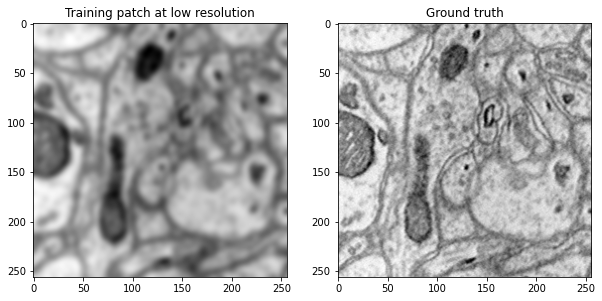

In [0]:
from skimage import filters

# Create corresponding training patches synthetically by adding noise
# and downsampling the images (see https://www.biorxiv.org/content/10.1101/740548v3)

def classic_crappify(img):
    img = filters.gaussian(img, sigma=3) + 1e-6
    return img

# Add noise
crappified_patches = [classic_crappify(x) for x in train_patches]

# Display corresponding first patch at low resolution
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow( crappified_patches[0], 'gray' )
plt.title( 'Training patch at low resolution' )
# Side by side with its "ground truth"
plt.subplot(1, 2, 2)
plt.imshow( train_patches[0], 'gray' )
plt.title( 'Ground truth' )

# NOTE: images have now values between 0.0 and 1.0

## Network definition
Next, we define our U-Net-like network, with 3 resolution levels in the contracting path, a bottleneck, and 3 resolution levels in the expanding path:

<figure>
<center>
<img src="https://drive.google.com/uc?id=1kjjBP4bTmDUKknRyEn1sF-sG1YZXmSxJ" width="750">
</figure>



As loss function, we use the mean squared error (MSE) between the expected and the predicted pixel values, and we also include the mean absolute error (MAE) as a control metric.


In [0]:
# Input image size
patch_shape = train_patches[0].shape
train_width = patch_shape[0]
train_height = patch_shape[1]


# Create U-Net for super-resolution

from keras.models import Model
from keras.layers import Input, UpSampling2D
from keras.layers import Dropout
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import AveragePooling2D
from keras.layers import concatenate

inputs = Input((train_width, train_height, 1))

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = AveragePooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = AveragePooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = AveragePooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)

u5 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c4)
u5 = concatenate([u5, c3])
c5 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u5)
c5 = Dropout(0.2) (c5)
c5 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c2])
c6 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.1) (c6)
c6 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c1], axis=3)
c7 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.1) (c7)
c7 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c7)

model = Model(inputs=[inputs], outputs=[outputs])
# compile the model with RMSProp as optimizer, MSE as loss function and MAE as metric
model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['mean_absolute_error'])
model.summary()

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 256, 256, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)    

## Training the network
To follow Tensorflow standards, the input and output of the network have to be reshaped ot 256 x 256 x 1. Notice both input and ground truth images have their intensities scaled between 0.0 and 1.0.

Important training information:
*   `Validation split`: percentage of training samples used for validation. Set to a random 10%.
*   `Epochs`: which defines the maximum number of epochs the model will be trained. Initially set to 20.
*   `Patience`: number of epochs that produced the monitored quantity (validation MSE) with no improvement after which training will be stopped. Initially set to 5.
*   `Batch size`:  the number of training examples in one forward/backward pass. Initially set to 6.



In [0]:
# Train the network
from keras.callbacks import EarlyStopping
import numpy as np

numEpochs = 20
earlystopper = EarlyStopping(patience=5, verbose=1, restore_best_weights=True)

# training input
input_shape = ( train_width, train_height, 1 ) # 256x256x1
X_train = [np.reshape(x, input_shape ) for x in crappified_patches]
X_train = np.asarray(X_train)

# training ground truth
output_shape = ( train_width, train_height, 1 ) # 256x256x1
Y_train = [x/255 for x in train_patches] # normalize between 0 and 1
Y_train = [np.reshape( x, output_shape ) for x in Y_train]
Y_train = np.asarray(Y_train)

# Train the model using a 10% validation split and batch size of 6
history = model.fit( X_train, Y_train, validation_split=0.1, batch_size = 6,
                    epochs=numEpochs, callbacks=[earlystopper])

Instructions for updating:
Use tf.cast instead.
Train on 1440 samples, validate on 160 samples
Epoch 1/20
1440/1440 [==============================] - 16s 11ms/step - loss: 0.0203 - mean_absolute_error: 0.1064 - val_loss: 0.0061 - val_mean_absolute_error: 0.0646
Epoch 2/20
1440/1440 [==============================] - 10s 7ms/step - loss: 0.0070 - mean_absolute_error: 0.0660 - val_loss: 0.0034 - val_mean_absolute_error: 0.0464
Epoch 3/20
1440/1440 [==============================] - 10s 7ms/step - loss: 0.0049 - mean_absolute_error: 0.0548 - val_loss: 0.0030 - val_mean_absolute_error: 0.0425
Epoch 4/20
1440/1440 [==============================] - 10s 7ms/step - loss: 0.0039 - mean_absolute_error: 0.0488 - val_loss: 0.0029 - val_mean_absolute_error: 0.0434
Epoch 5/20
1440/1440 [==============================] - 10s 7ms/step - loss: 0.0034 - mean_absolute_error: 0.0458 - val_loss: 0.0020 - val_mean_absolute_error: 0.0342
Epoch 6/20
1440/1440 [==============================] - 10s 7ms/step 


We can now plot the loss and MAE curves for the training and validation sets.


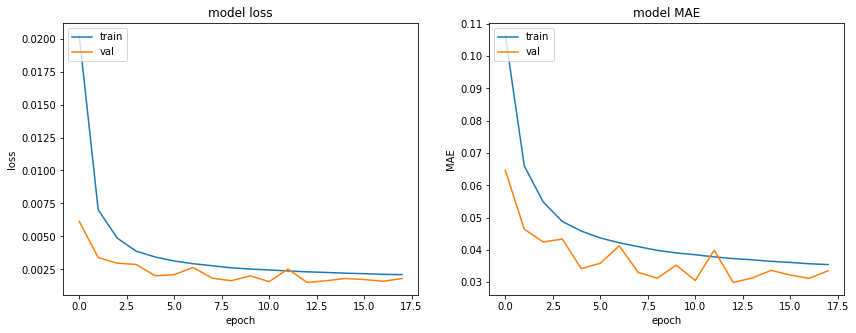

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))

# summarize history for loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

# summarize history for MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


## Check performance in the test set
Finally we can load some test images for testing.

In [0]:
# Now we load some unseen images for testing
test_path = 'drive/My Drive/Neubias-TS15-images/test/'

test_filenames = [x for x in os.listdir( test_path ) if x.endswith(".tif")]

print( 'Available test images: ' + str( len(test_filenames)) )

Available test images: 10


Text(0.5, 1.0, 'Ground truth')

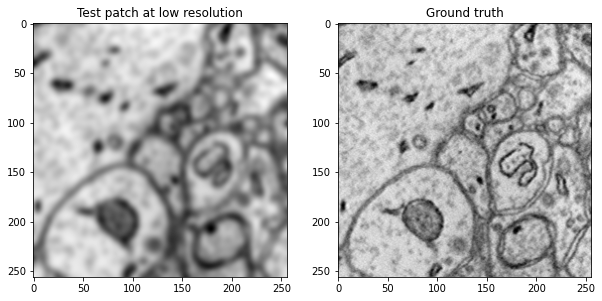

In [0]:
# Read test images
test_img = [ img_as_ubyte( io.imread( test_path + x ) ) for x in test_filenames ]

# Create patches the same way as before
test_patches = create_patches( test_img, 4, 4 )

# Add noise
crappified_test_patches = [classic_crappify(x) for x in test_patches]

# Display corresponding first patch at low resolution
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow( crappified_test_patches[0], 'gray' )
plt.title( 'Test patch at low resolution' )
# Side by side with its "ground truth"
plt.subplot(1, 2, 2)
plt.imshow( test_patches[0], 'gray' )
plt.title( 'Ground truth' )



We can evaluate the network performance in test using both the MSE and MAE metrics.


In [0]:
# Evaluate trained network on test images
X_test = [np.reshape(x, input_shape ) for x in crappified_test_patches]
X_test = np.asarray(X_test)

Y_test = [x/255 for x in test_patches] # normalize between 0 and 1
Y_test = [np.reshape( x, output_shape ) for x in Y_test]
Y_test = np.asarray(Y_test)

# Evaluate the model on the test data using `evaluate`
print('\n# Evaluate on test data')
results = model.evaluate(X_test, Y_test , batch_size=16)
print('test loss, test MAE:', results)




# Evaluate on test data
160/160 [==============================] - 0s 3ms/step
test loss, test MAE: [0.0020451603922992945, 0.034192585945129396]


And also display some patches for qualitative evaluation.


# Generate predictions for 3 samples
predictions shape: (3, 256, 256, 1)


Text(0.5, 1.0, 'Prediction')

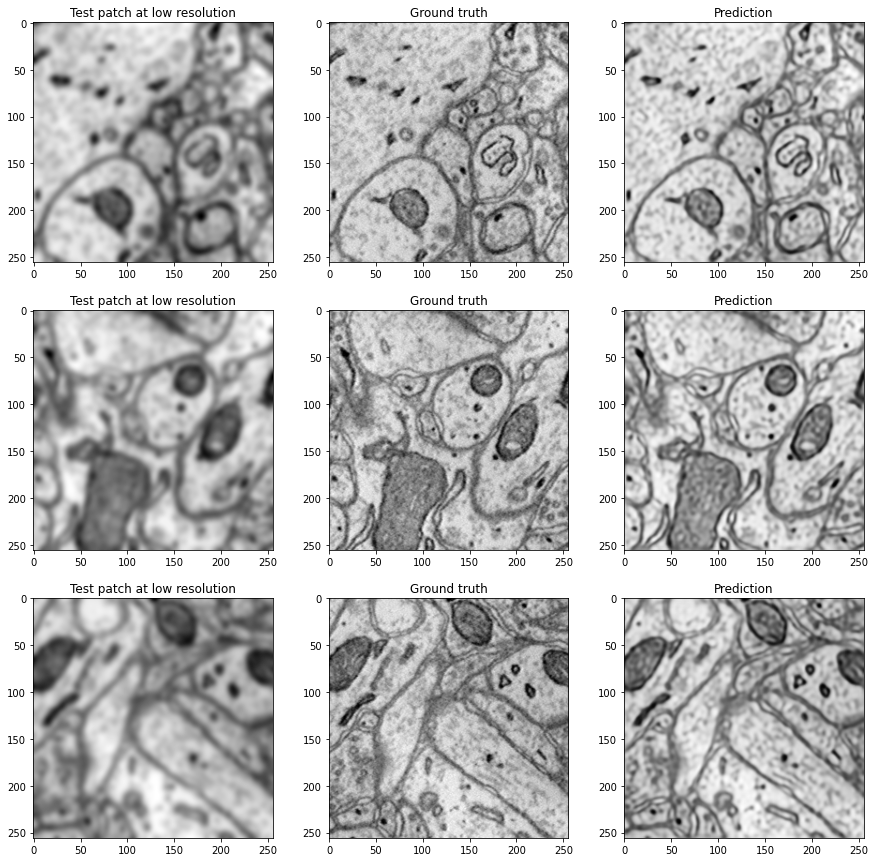

In [0]:
print('\n# Generate predictions for 3 samples')
predictions = model.predict(X_test[:3])
print('predictions shape:', predictions.shape)

# Display corresponding first 3 patches
plt.figure(figsize=(15,15))
plt.subplot(3, 3, 1)
plt.imshow( crappified_test_patches[0], 'gray' )
plt.title( 'Test patch at low resolution' )
# Side by side with its "ground truth"
plt.subplot(3, 3, 2)
plt.imshow( test_patches[0], 'gray' )
plt.title( 'Ground truth' )
# ant its prediction
plt.subplot(3, 3, 3)
plt.imshow( predictions[0,:,:,0], 'gray' )
plt.title( 'Prediction' )

plt.subplot(3, 3, 4)
plt.imshow( crappified_test_patches[1], 'gray' )
plt.title( 'Test patch at low resolution' )
# Side by side with its "ground truth"
plt.subplot(3, 3, 5)
plt.imshow( test_patches[1], 'gray' )
plt.title( 'Ground truth' )
# ant its prediction
plt.subplot(3, 3, 6)
plt.imshow( predictions[1,:,:,0], 'gray' )
plt.title( 'Prediction' )

plt.subplot(3, 3, 7)
plt.imshow( crappified_test_patches[2], 'gray' )
plt.title( 'Test patch at low resolution' )
# Side by side with its "ground truth"
plt.subplot(3, 3, 8)
plt.imshow( test_patches[2], 'gray' )
plt.title( 'Ground truth' )
# ant its prediction
plt.subplot(3, 3, 9)
plt.imshow( predictions[2,:,:,0], 'gray' )
plt.title( 'Prediction' )

## Save model to import it later in DeepImageJ
Now, we will see how to saved the train model into a file so we can later reuse it in the [DeepImageJ plugin](https://deepimagej.github.io/deepimagej/index.html).

In [0]:
# !rm -rf save_model

# Save entire model to the Tensorflow format SavedModel

import tensorflow as tf
import keras
from keras import backend as K

OUTPUT_DIR = "./saved_model"

builder = tf.saved_model.builder.SavedModelBuilder(OUTPUT_DIR)

signature = tf.saved_model.signature_def_utils.predict_signature_def(
            inputs  = {'input':  model.input},
            outputs = {'output': model.output})

signature_def_map = { tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY: signature }

builder.add_meta_graph_and_variables(K.get_session(), [tf.saved_model.tag_constants.SERVING],
                                             signature_def_map=signature_def_map)
builder.save()

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ./saved_model/saved_model.pb


b'./saved_model/saved_model.pb'

In [0]:
# Check if the folder has been properly created
!ls -l

total 12
drwx------ 4 root root 4096 Apr 18 15:26 drive
drwxr-xr-x 1 root root 4096 Apr  3 16:24 sample_data
drwxr-xr-x 3 root root 4096 Apr 18 15:35 saved_model


In [0]:
# Zip folder with the save model
from google.colab import files

!zip saved_model -r saved_model/

  adding: saved_model/ (stored 0%)
  adding: saved_model/saved_model.pb (deflated 90%)
  adding: saved_model/variables/ (stored 0%)
  adding: saved_model/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: saved_model/variables/variables.index (deflated 51%)


In [0]:
# Check if the file is there
!ls -l

total 3492
drwx------ 4 root root    4096 Apr 18 15:26 drive
drwxr-xr-x 1 root root    4096 Apr  3 16:24 sample_data
drwxr-xr-x 3 root root    4096 Apr 18 15:35 saved_model
-rw-r--r-- 1 root root 3561213 Apr 18 15:35 saved_model.zip


In [0]:
# And download!
files.download("saved_model.zip")